**Collaborated with students Sophie Guo, Fanxi Chen, and Yixin Zhao**

### Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cars = pd.read_csv("../W7/train.csv")
cars.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


### 1. Visualize the distribution of price

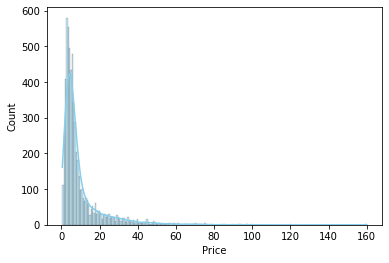

In [2]:
sns.histplot(cars["Price"], color = "skyblue", label = "Price", kde = True)
plt.show()

*Price is not normally distributed - it is missing the left half of the "bell". The rule-of-thumb transformation for data of this shape would be log.*

### 2. Transform Price so that it looks more normal

<AxesSubplot:xlabel='LogPrice', ylabel='Count'>

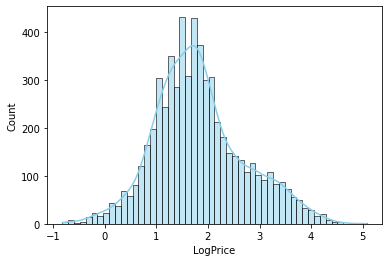

In [3]:
cars["LogPrice"] = np.log(cars["Price"])
sns.histplot(x = cars["LogPrice"], color = "skyblue", label = "Price", kde = True)

*With log-transformation, the new price looks roughly normal.*

### 3. Build a model of transformed price based on the other 4 variables, how much variance is explained?

In [4]:
# transform dataset

# delete units in column
cars["Power"] = cars["Power"].str.rstrip(" bhp")
cars["Engine"] = cars["Engine"].str.rstrip(" CC")
# replace "null" with NaN
cars["Power"] = cars["Power"].replace(regex="null", value = np.nan)
# fix data types (from string to float)
cars["Power"] = cars["Power"].astype("float")
cars["Engine"] = cars["Engine"].astype("float")

In [5]:
# select needed columns and drop NA
car = cars.loc[:, ["Power", "Engine", "Kilometers_Driven", "Year", "Price", "LogPrice"]]
car.dropna(inplace = True)
car.reset_index(inplace=True, drop=True)  # reset index to make continuous index (index missing from NaN removal)
car.head()

,Power,Engine,Kilometers_Driven,Year,Price,LogPrice
0,58.16,998.0,72000,2010,1.75,0.559616
1,126.20,1582.0,41000,2015,12.50,2.525729
2,88.70,1199.0,46000,2011,4.50,1.504077
3,88.76,1248.0,87000,2012,6.00,1.791759
4,140.80,1968.0,40670,2013,17.74,2.875822


In [6]:
# build regression model
import statsmodels.api as sm

y = car["LogPrice"]
x = car[["Power", "Engine", "Kilometers_Driven", "Year"]]
x = sm.add_constant(x)

model_4p = sm.OLS(y, x).fit()
print(model_4p.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     7279.
Date:                Wed, 12 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:52:49   Log-Likelihood:                -2234.0
No. Observations:                5876   AIC:                             4478.
Df Residuals:                    5871   BIC:                             4511.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -271.9753      3.01

*Around 83.2% of variance in the (log) price can be explained by the model composed of Power, Engine, Kilometers Driven, and Year.*

### 4. Compute the VIF of each variable, which 2 are potential problems?

In [7]:
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

outcome, predictors = dmatrices("LogPrice ~ Power+Engine+Kilometers_Driven+Year", data = car, return_type = "dataframe")

# calculate VIF for each explanatory variable
vif_4p = pd.DataFrame()
vif_4p["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif_4p['variable'] = predictors.columns

# view VIF for each explanatory variable 
vif_4p

,VIF,variable
0,425843.625194,Intercept
1,4.115131,Power
2,4.156524,Engine
3,1.042054,Kilometers_Driven
4,1.051550,Year


*Power and Engine might have potential problems, with VIF values higher than 3.*

### 5. Use PCA to create principal components and create a scree plot

In [8]:
# Standardization predictors
from sklearn.preprocessing import StandardScaler

x = car.loc[:, ["Power", "Engine", "Kilometers_Driven", "Year"]].values
x = StandardScaler().fit_transform(x)

Text(0, 0.5, 'Cumulative % Variance Explained')

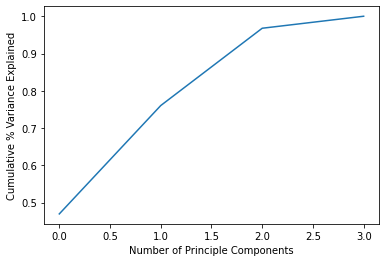

In [9]:
# conduct PCA on the four predictors to find out optimal number of components to use
from sklearn.decomposition import PCA
pca_tune = PCA().fit(x.data)

# scree plot
plt.plot( np.cumsum(pca_tune.explained_variance_ratio_) )
plt.xlabel("Number of Principle Components")
plt.ylabel("Cumulative % Variance Explained")

*The cumulative variance explained graph shows that after 2 components, the total variance explained does not improve much. Therefore, the optimal number of components to use would be 2.*

In [10]:
# conduct PCA for dimensionality reduction
pca = PCA(n_components = 2) # dimension reduced from 4 to 2
principalComponents = pca.fit_transform(x) # 2D-array of principle components
principalDf = pd.DataFrame(principalComponents, columns = ['principal_component_1', 'principal_component_2'])

In [11]:
# create a new data frame with the identified principle components and outcome (log of price)
finalDf = pd.concat([principalDf, car["LogPrice"]], axis = 1)
finalDf.head()

,principal_component_1,principal_component_2,LogPrice
0,-1.359609,1.066173,0.559616
1,0.064058,-0.501776,2.525729
2,-0.781486,0.555761,1.504077
3,-0.693321,0.633934,1.791759
4,0.745730,-0.118226,2.875822


In [12]:
# show the variance explained by each component
pca.explained_variance_ratio_

array([0.46973362, 0.29070772])

### 6. Create / select 2 components and rerun the regression with transformed price, what is the amount of variance explained?

In [13]:
# run regression again with identified principle components
x2 = finalDf[["principal_component_1", "principal_component_2"]]
x2 = sm.add_constant(x2)

model_2c = sm.OLS(finalDf["LogPrice"], x2).fit()
print(model_2c.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     8291.
Date:                Wed, 12 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:52:50   Log-Likelihood:                -3538.0
No. Observations:                5876   AIC:                             7082.
Df Residuals:                    5873   BIC:                             7102.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.84

*Around 73.8% of variance in the (log) price can be explained by the two principle components produced by PCA. There is a decrease in R-sqaured by 9%.*

### 7. What is the VIF of the components?

In [14]:
yy, XX = dmatrices("LogPrice ~ principal_component_1+principal_component_2", data = finalDf, return_type = "dataframe")

vif_2c = pd.DataFrame()
vif_2c["VIF"] = [variance_inflation_factor(XX.values, i) for i in range(XX.shape[1])]
vif_2c['variable'] = XX.columns

vif_2c

,VIF,variable
0,1.0,Intercept
1,1.0,principal_component_1
2,1.0,principal_component_2


*The VIF of both principle components is 1. It means collinearity is no longer a concern. PCA has efficiently reduced dimensionality and fixed collinearity problem.*